<h1 style="color:steelblue; font-family:Ewert; font-size:150%;" class="font-effect-fire-animation">Code Libraries, Style and Links</h1>

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d|fire-animation');
span {font-family:'Roboto'; color:black; text-shadow:4px 4px 4px #aaa;}  
div.output_area pre{font-family:'Roboto'; font-size:120%; color: steelblue;}      
</style>

In [2]:
import numpy as np,pandas as pd
import keras as ks, pylab as pl
import os,ast,h5py
import warnings; warnings.filterwarnings('ignore')
pl.style.use('seaborn-whitegrid')
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation,Dropout,Dense
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D

Using TensorFlow backend.


In [3]:
style_dict={'background-color':'gainsboro','color':'steelblue', 
            'border-color':'white','font-family':'Roboto'}
I=64 # image size in pixels
S=1 # number of the label set {1, ..., 10} -> {1-34, ..., 307-340}
T=20 # number of labels in one set 
N=7000 # number of images with the same label in the training set
files=os.listdir("../input/train_simplified")
print(sorted(files))

['The Eiffel Tower.csv', 'The Great Wall of China.csv', 'The Mona Lisa.csv', 'airplane.csv', 'alarm clock.csv', 'ambulance.csv', 'angel.csv', 'animal migration.csv', 'ant.csv', 'anvil.csv', 'apple.csv', 'arm.csv', 'asparagus.csv', 'axe.csv', 'backpack.csv', 'banana.csv', 'bandage.csv', 'barn.csv', 'baseball bat.csv', 'baseball.csv', 'basket.csv', 'basketball.csv', 'bat.csv', 'bathtub.csv', 'beach.csv', 'bear.csv', 'beard.csv', 'bed.csv', 'bee.csv', 'belt.csv', 'bench.csv', 'bicycle.csv', 'binoculars.csv', 'bird.csv', 'birthday cake.csv', 'blackberry.csv', 'blueberry.csv', 'book.csv', 'boomerang.csv', 'bottlecap.csv', 'bowtie.csv', 'bracelet.csv', 'brain.csv', 'bread.csv', 'bridge.csv', 'broccoli.csv', 'broom.csv', 'bucket.csv', 'bulldozer.csv', 'bus.csv', 'bush.csv', 'butterfly.csv', 'cactus.csv', 'cake.csv', 'calculator.csv', 'calendar.csv', 'camel.csv', 'camera.csv', 'camouflage.csv', 'campfire.csv', 'candle.csv', 'cannon.csv', 'canoe.csv', 'car.csv', 'carrot.csv', 'castle.csv', 'cat

In [4]:
# additional functions
def get_line(x1,y1,x2,y2):
    steep=abs(y2-y1)>abs(x2-x1)
    if steep: x1,y1,x2,y2=y1,x1,y2,x2
    rev=False
    if x1>x2:
        x1,x2,y1,y2=x2,x1,y2,y1
        rev=True
    dx=x2-x1; dy=abs(y2-y1)
    error=int(dx/2)
    xy=[]; y=y1; ystep=None
    if y1<y2: ystep=1
    else: ystep=-1
    for x in range(x1,x2+1):
        if steep: xy.append([y,x])
        else: xy.append([x,y])
        error-=dy
        if error<0:
            y+=ystep
            error+=dx
    if rev: xy.reverse()
    return xy
def display_drawing():
    for k in range (5) :  
        pl.figure(figsize=(10,2))
        pl.suptitle(files[(S-1)*T+k])
        for i in range(5):
            picture=ast.literal_eval(data[labels[(S-1)*T+k]].values[i])
            for x,y in picture:
                pl.subplot(1,5,i+1)
                pl.plot(x,y,'-o',markersize=2,color='slategray')
                pl.xticks([]); pl.yticks([])
            pl.gca().invert_yaxis()
            pl.axis('equal');            
def get_image(data,k,I=I):
    img=np.zeros((280,280))
    picture=ast.literal_eval(data.values[k])
    for x,y in picture:
        for i in range(len(x)):
            img[y[i]+10][x[i]+10]=1
            if (i<len(x)-1):
                x1,y1,x2,y2=x[i],y[i],x[i+1],y[i+1]
            else:
                x1,y1,x2,y2=x[i],y[i],x[0],y[0]
            for [xl,yl] in get_line(x1,y1,x2,y2):
                img[yl+10][xl+10]=1                
    return resize(img,(I,I))    

<h1 style="color:steelblue; font-family:Ewert; font-size:150%;" class="font-effect-fire-animation">Data Exploration</h1>

In [5]:
fpath='../input/train_simplified/'
data_alarm_clock=pd.read_csv(fpath+'alarm clock.csv',index_col='key_id')
data_alarm_clock.tail(3).T.style.set_properties(**style_dict)

key_id,5271472241115136,4784121630949376,4518734997749760
countrycode,US,CH,PH
drawing,"[[[150, 133, 114, 91, 76, 66, 59, 58, 62, 75, 97, 120, 147, 169, 177, 171, 152], [33, 22, 23, 32, 43, 54, 69, 88, 103, 117, 123, 119, 105, 84, 65, 46, 36]], [[77, 70, 68, 73, 79, 88, 99, 98, 90, 83, 75], [41, 32, 23, 6, 2, 2, 13, 26, 43, 44, 36]], [[148, 146, 154, 171, 182, 186, 186, 175], [29, 23, 8, 0, 2, 8, 18, 51]], [[116, 117, 129, 129], [22, 9, 9, 21]], [[204, 242], [15, 10]], [[217, 255], [58, 64]], [[221, 240], [94, 109]], [[20, 11, 0], [35, 34, 39]], [[21, 4], [90, 99]], [[20, 7, 3], [111, 126, 138]], [[87, 94], [64, 65]], [[83, 83], [116, 116]], [[83, 113], [117, 67]], [[131, 153], [114, 129]], [[112, 130], [63, 51]], [[113, 113], [60, 60]], [[114, 113], [59, 59]], [[131, 132, 134, 137], [52, 51, 59, 63]], [[130, 110, 130], [52, 84, 93]], [[133, 124], [86, 86]], [[135, 118], [83, 101]], [[194, 194], [43, 43]]]","[[[55, 35, 12, 1, 0, 7, 23, 43, 71, 114, 137, 151, 168, 177, 194, 196, 188, 168, 157, 147, 115, 97, 86, 76, 56], [78, 85, 106, 140, 163, 191, 229, 247, 255, 255, 252, 246, 232, 219, 177, 151, 117, 77, 64, 58, 51, 50, 54, 59, 88]], [[119, 124, 162, 116, 167, 175, 181, 169, 143], [48, 41, 15, 1, 1, 5, 18, 17, 6]], [[64, 64], [68, 61]]]","[[[139, 141, 128, 109, 84, 50, 37, 21, 14, 6, 1, 1, 14, 39, 59, 80, 124, 160, 174, 186, 190, 194, 191, 177, 141, 119, 108, 106], [115, 44, 29, 17, 11, 10, 14, 24, 33, 50, 74, 132, 169, 203, 215, 219, 218, 205, 192, 171, 155, 116, 99, 81, 49, 40, 40, 45]], [[82, 74, 62, 37, 22, 7, 7, 22, 39, 86, 118, 124, 142, 147, 146, 130, 116, 101, 85, 56, 50, 49], [31, 30, 36, 51, 65, 97, 130, 162, 177, 196, 199, 195, 174, 138, 113, 69, 50, 39, 33, 33, 42, 51]], [[73, 67, 63, 62, 66, 82, 86, 82, 71, 63], [93, 94, 103, 114, 120, 119, 109, 96, 90, 91]], [[109, 89, 79], [64, 84, 105]], [[89, 111], [108, 157]], [[63, 47, 44, 45, 57, 71, 83, 83, 79, 70, 52, 46, 48], [4, 6, 11, 24, 36, 37, 27, 20, 14, 6, 0, 2, 10]], [[80, 63, 48], [203, 218, 247]], [[127, 160], [197, 255]]]"
recognized,False,True,True
timestamp,2017-03-13 05:24:21.781230,2017-03-13 10:55:46.870220,2017-03-10 12:33:17.893550
word,alarm clock,alarm clock,alarm clock


In [6]:
labels=[el.replace(" ","_")[:-4] for el in files]
data = pd.DataFrame(index=range(N),columns=labels[(S-1)*T:S*T])
for i in range((S-1)*T,S*T):
    data[labels[i]]=pd.read_csv(fpath+files[i],
                                index_col='key_id').drawing.values[:N]
data.shape

(7000, 20)

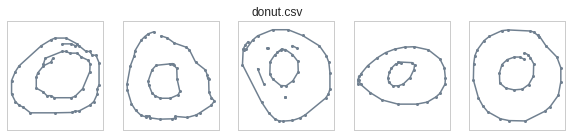

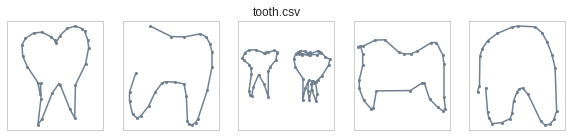

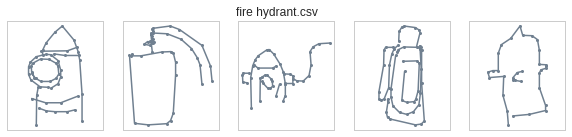

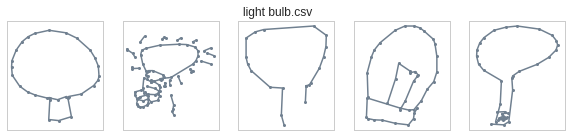

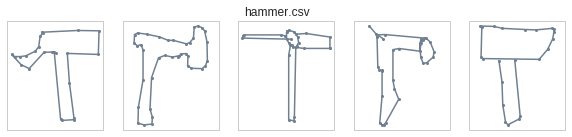

In [7]:
display_drawing()

In [8]:
images=[]
for label in labels[(S-1)*T:S*T]:
    images.extend([get_image(data[label],i) for i in range(N)])    
images=np.array(images)
del data,data_alarm_clock 
images.shape

(140000, 64, 64)

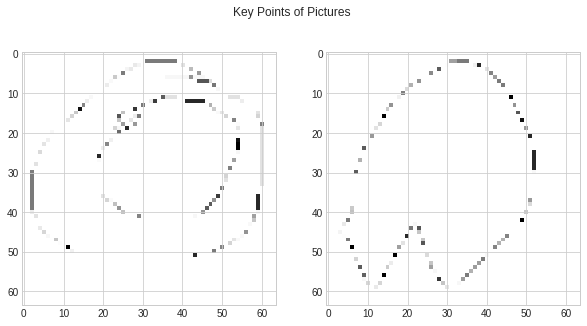

In [9]:
pl.figure(figsize=(10,5))
pl.subplot(121); pl.imshow(images[0])
pl.subplot(122); pl.imshow(images[10000])
pl.suptitle('Key Points of Pictures');

In [10]:
targets=np.array([[]+N*[k] for k in range(T)])
targets=ks.utils.to_categorical(targets,T).reshape(N*T,T)
targets.shape

(140000, 20)

In [11]:
with h5py.File('QuickDrawImages001-020.h5','w') as f:
    f.create_dataset('images',data=images)
    f.create_dataset('targets',data=targets)
    f.close()

In [12]:
x_train,x_test,y_train,y_test=\
train_test_split(images,targets,test_size=0.2,random_state=1)
n=int(len(x_test)/2)
x_valid,y_valid=x_test[:n],y_test[:n]
x_test,y_test=x_test[n:],y_test[n:]
del images,targets
x_train=x_train.reshape(-1,I,I,1)
x_valid=x_valid.reshape(-1,I,I,1)
x_test=x_test.reshape(-1,I,I,1)
y_train.shape,y_valid.shape,y_test.shape

((112000, 20), (14000, 20), (14000, 20))

<h1 style="color:steelblue; font-family:Ewert; font-size:150%;" class="font-effect-fire-animation">The Model</h1>

In [13]:
def model():
    model=Sequential()    
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=.02))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=.02))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(GlobalMaxPooling2D())   
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))     
    model.add(Dense(T))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model
model=model()

In [14]:
fw='weights.best.model.hdf5'
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',
                               patience=5,verbose=2,factor=.75)
history=model.fit(x_train,y_train,epochs=100,
                  batch_size=1024,verbose=2,
                  validation_data=(x_valid,y_valid),
                  callbacks=[checkpointer,lr_reduction])

Train on 112000 samples, validate on 14000 samples
Epoch 1/100
 - 30s - loss: 2.4236 - acc: 0.2484 - val_loss: 1.9814 - val_acc: 0.3957

Epoch 00001: val_loss improved from inf to 1.98145, saving model to weights.best.model.hdf5
Epoch 2/100
 - 21s - loss: 1.7644 - acc: 0.4435 - val_loss: 1.5665 - val_acc: 0.5265

Epoch 00002: val_loss improved from 1.98145 to 1.56652, saving model to weights.best.model.hdf5
Epoch 3/100
 - 21s - loss: 1.5127 - acc: 0.5229 - val_loss: 1.3936 - val_acc: 0.5776

Epoch 00003: val_loss improved from 1.56652 to 1.39365, saving model to weights.best.model.hdf5
Epoch 4/100
 - 21s - loss: 1.3715 - acc: 0.5679 - val_loss: 1.2821 - val_acc: 0.6074

Epoch 00004: val_loss improved from 1.39365 to 1.28210, saving model to weights.best.model.hdf5
Epoch 5/100
 - 21s - loss: 1.2751 - acc: 0.6005 - val_loss: 1.2014 - val_acc: 0.6356

Epoch 00005: val_loss improved from 1.28210 to 1.20142, saving model to weights.best.model.hdf5
Epoch 6/100
 - 21s - loss: 1.2091 - acc: 0.

<h1 style="color:steelblue; font-family:Ewert; font-size:200%;" class="font-effect-fire-animation">Evaluation</h1>

In [15]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

14000/14000 [==============================] - 1s 88us/step


[0.6245868108953748, 0.8169285714285714]

In [16]:
p_test=model.predict(x_test)
well_predicted=[]
for p in range(len(x_test)):
    if (np.argmax(p_test[p])==np.argmax(y_test[p])):
        well_predicted.append(labels[(S-1)*T+np.argmax(p_test[p])])
u=np.unique(well_predicted,return_counts=True)
pd.DataFrame({'labels':u[0],'correct predictions':u[1]})\
.sort_values('correct predictions',ascending=False)\
.style.set_properties(**style_dict)

,labels,correct predictions
17,television,640
14,pear,637
4,donut,628
1,asparagus,624
10,light_bulb,618
13,moon,617
15,sailboat,605
19,violin,587
2,calendar,579
18,tooth,579


<h1 style="color:steelblue; font-family:Ewert; font-size:150%;" class="font-effect-fire-animation">The Next Step</h1>
The weights for each label set have saved in the special database and will be used for image recognition in the test data.<br/>
The next notebook [Quick, Draw! Doodle Recognition 2](https://www.kaggle.com/olgabelitskaya/quick-draw-doodle-recognition-2)